Dla danego szeregowania należy wyliczyć wartość kary oraz optymalna kolejność zadań

Dane skladaja sie z trzech tabel
- czas produkcji
- waga (wysokość kary)
- pozadany czas produkcji

### LAB 4

Obliczanie wartości kary na podstawie zadanej kolejności zadań



In [24]:
file = "witi.data.txt"
def load_data(data_name):
    data = []
    with open(file, 'r') as f:
        append = False
        for line in f.readlines():
            if line.startswith("\n"):
                append = False
                
            if append:
                s = line.strip()
                s = s.split()
                if len(s) <= 1:
                    continue
                
                data.append([int(s[0]), int(s[1]), int(s[2])])
            if line.startswith(data_name):
                append = True

    return data
print(load_data("data.10"))

[[1, 2, 748], [46, 5, 216], [5, 7, 673], [93, 4, 514], [83, 1, 52], [53, 7, 7], [38, 1, 413], [68, 6, 922], [84, 5, 91], [65, 4, 694]]


In [25]:
data_names = []
for i in range(10, 21):
    data_names.append("data." + str(i))
print(data_names)

['data.10', 'data.11', 'data.12', 'data.13', 'data.14', 'data.15', 'data.16', 'data.17', 'data.18', 'data.19', 'data.20']


In [ ]:
def calculate_raw(data):
    penalty = 0
    time = 0
    order = []
    for i in range(len(data)):
        time += data[i][0]
        delay = max(0, time - data[i][2])
        penalty += data[i][1] * delay
    return penalty, data
data = load_data("data.11")
penalty, order = calculate_raw(data)
print("Najlepsza kara:", penalty)
print("Najlepsza kolejność:" + "".join(str(i + 1) + " " for i in range(len(order))))
        

Najlepsza kara: 6323
Najlepsza kolejność:1 2 3 4 5 6 7 8 9 10 11 


In [ ]:
def calculate_brute_force(tasks):
    n = len(tasks)
    min_penalty = float('inf')
    best_order = []

    # Całkowita kara dla permutacji
    def calculate_penalty(order):
        time = 0
        penalty = 0

        for i in order:
            time += tasks[i][0]
            delay = max(0, time - tasks[i][2])
            penalty += tasks[i][1] * delay
        return penalty

    # Rekurencyjna funkcja generująca wszystkie permutacje zadań
    def generate(k, order):
        nonlocal min_penalty, best_order

        if k == n:
            penalty = calculate_penalty(order)
            if penalty < min_penalty:
                min_penalty = penalty
                best_order = order[:]  # kopiuje tablice
            return

        for i in range(k, n):
            order[k], order[i] = order[i], order[k]
            generate(k + 1, order)
            order[k], order[i] = order[i], order[k]
    generate(0, list(range(n)))
    
    return min_penalty, [i + 1 for i in best_order]

data = load_data("data.10")
penalty, order = calculate_brute_force(data)
print("Najlepsza kara:", penalty)
print("Najlepsza kolejność:", order)


Najlepsza kara: 766
Najlepsza kolejność: [6, 9, 2, 5, 4, 1, 7, 8, 3, 10]


In [ ]:
import math

def calculate_pd(tasks):
    n = len(tasks)
    total_states = 2 ** n

    penalties = [math.inf] * total_states
    penalties[0] = 0

    completion_time = [0] * total_states
    previous_task = [-1] * total_states

    # Czas zakończenia dla każdego stanu (maska binarna)
    for state in range(total_states):
        for task in range(n):
            if (state & (1 << task)) != 0:
                completion_time[state] += tasks[task][0]

    # Programowanie dynamiczne
    for current_state in range(total_states):
        for task in range(n):
            bit = 1 << task
            if current_state & bit:
                prev_state = current_state - bit
                end_time = completion_time[current_state]
                delay = max(0, end_time - tasks[task][2])
                penalty = tasks[task][1] * delay

                if penalties[current_state] > penalties[prev_state] + penalty:
                    penalties[current_state] = penalties[prev_state] + penalty
                    previous_task[current_state] = task

    # Odtworzenie kolejności zadań
    order = []
    state = total_states - 1
    while state:
        task = previous_task[state]
        order.append(task + 1)
        state -= 1 << task

    return penalties[total_states - 1], order[::-1]

data = load_data("data.11")
penalty, order = calculate_pd(data)
print("Minimalna kara:", penalty)
print("Optymalna kolejność zadań:", ' '.join(str(i) for i in order))

Minimalna kara: 799
Optymalna kolejność zadań: 6 9 2 11 5 7 10 4 8 3 1


In [ ]:
import math

def calculate_pd_lex_min(tasks):
    n = len(tasks)
    total_states = 1 << n
    penalties = [math.inf] * total_states
    completion_time = [0] * total_states

    penalties[0] = 0

    # Czas zakończenia dla każdego stanu (maska binarna)
    for state in range(total_states):
        for i in range(n):
            if state & (1 << i):
                completion_time[state] += tasks[i][0]

    # Programowanie dynamiczne
    for state in range(total_states):
        for task in range(n):
            bit = 1 << task
            if not (state & bit):
                new_state = state | bit
                end_time = completion_time[new_state]
                delay = max(0, end_time - tasks[task][2])
                penalty = tasks[task][1] * delay
                penalties[new_state] = min(penalties[new_state], penalties[state] + penalty)

    # Odtwarzanie kolejności
    order = []
    state = total_states - 1
    while state != 0:
        for task in range(n):
            bit = 1 << task
            if state & bit:
                prev_state = state ^ bit
                end_time = completion_time[state]
                delay = max(0, end_time - tasks[task][2])
                penalty = tasks[task][1] * delay
                if penalties[state] == penalties[prev_state] + penalty:
                    order.append(task + 1)
                    state = prev_state
                    break

    return penalties[(1 << n) - 1], order[::-1]

data = load_data("data.11")
penalty, order = calculate_pd_lex_min(data)
print("Minimalna kara:", penalty)
print("Optymalna kolejność zadań:", ' '.join(str(i) for i in order))

Minimalna kara: 799
Optymalna kolejność zadań: 6 9 2 11 5 7 10 4 8 3 1


C:\Users\Marek\AppData\Local\Temp\ipykernel_18684\3730046829.py:7: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return a * np.array([np.math.factorial(int(x)) for x in n]) + b
C:\Users\Marek\AppData\Local\Temp\ipykernel_18684\3730046829.py:26: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(factorial_model, n_values, times)


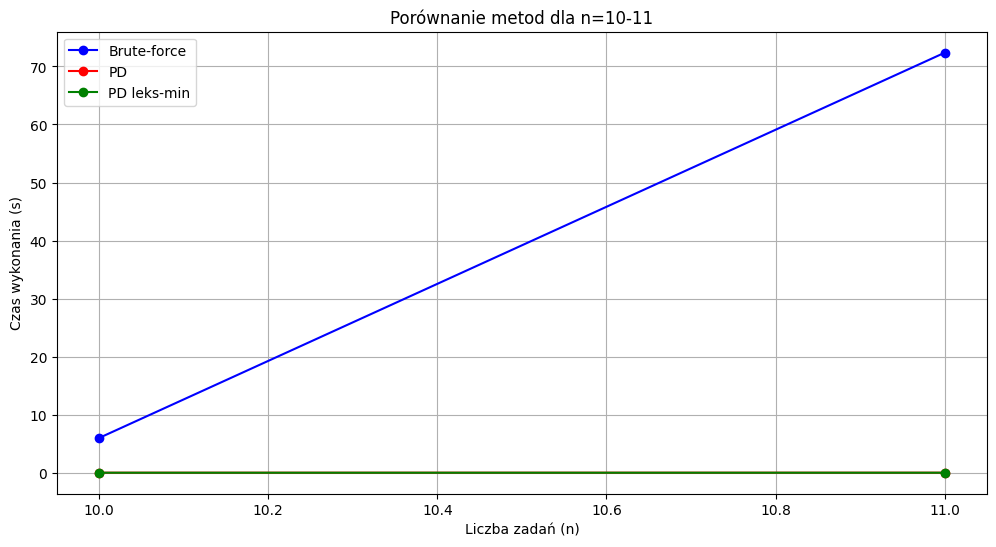

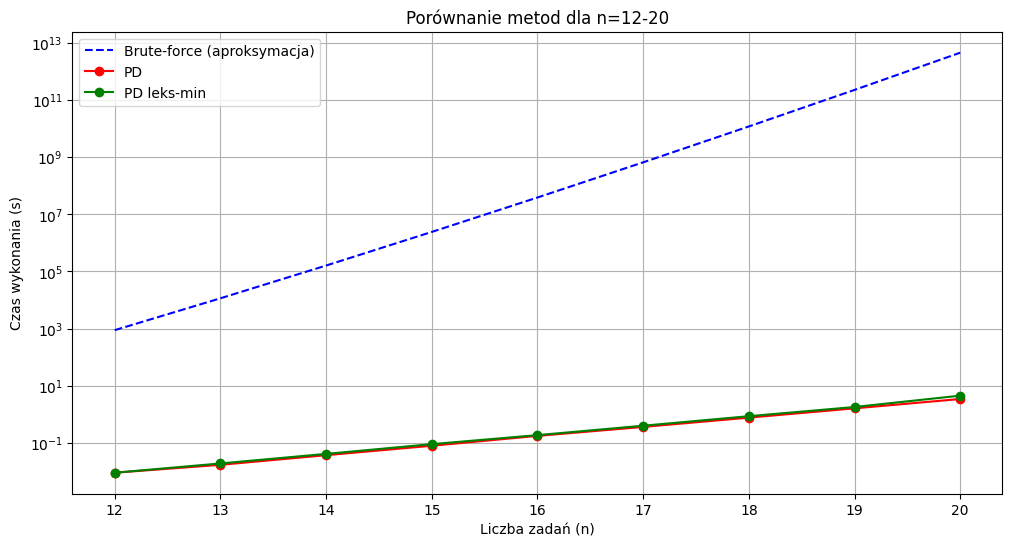

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def factorial_model(n, a, b):
    return a * np.array([np.math.factorial(int(x)) for x in n]) + b

def compare_methods_split_plots():
    data_sizes = list(range(10, 21))
    bf_times = []
    pd_times = []
    pd_lex_times = []
    
    exact_bf_measurements = {}
    for n in [10, 11]:
        tasks = load_data(f"data.{n}")
        start = time.time()
        calculate_brute_force(tasks)
        exact_bf_measurements[n] = time.time() - start
    
    n_values = np.array(list(exact_bf_measurements.keys()))
    times = np.array(list(exact_bf_measurements.values()))
    popt, _ = curve_fit(factorial_model, n_values, times)
    
    for n in data_sizes:
        tasks = load_data(f"data.{n}")
        
        start = time.time()
        calculate_pd(tasks)
        pd_times.append(time.time() - start)
        
        start = time.time()
        calculate_pd_lex_min(tasks)
        pd_lex_times.append(time.time() - start)
        
        if n in exact_bf_measurements:
            bf_times.append(exact_bf_measurements[n])
        else:
            bf_times.append(factorial_model(np.array([n]), *popt)[0])

    small_n = data_sizes[:2]
    large_n = data_sizes[2:]

    plt.figure(figsize=(12, 6))
    plt.plot(small_n, bf_times[:2], 'b-o', label='Brute-force')
    plt.plot(small_n, pd_times[:2], 'r-o', label='PD')
    plt.plot(small_n, pd_lex_times[:2], 'g-o', label='PD leks-min')
    plt.xlabel('Liczba zadań (n)')
    plt.ylabel('Czas wykonania (s)')
    plt.title('Porównanie metod dla n=10-11')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(large_n, bf_times[2:], 'b--', label='Brute-force (aproksymacja)')
    plt.plot(large_n, pd_times[2:], 'r-o', label='PD')
    plt.plot(large_n, pd_lex_times[2:], 'g-o', label='PD leks-min')
    plt.xlabel('Liczba zadań (n)')
    plt.ylabel('Czas wykonania (s)')
    plt.title('Porównanie metod dla n=12-20')
    plt.yscale('log')
    plt.legend()
    plt.grid()
    plt.show()

compare_methods_split_plots()